# Regression Kriging: Comparing Covariates

This document includes Python codes that compare regression kriging with 1) bathymatry, 2) LDI, 3) basymatry+ LDI.

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Preprocess](#preprocess)
* [3. Combine Data](#read_data)
* [4. Spatial Interpolation of Dissolved Oxygen](#do_interpolate)
    * [4.1 Kriging:Dissolved Oxygen](#do_kriging)
    * [4.2 IDW:Dissolved Oxygen](#do_idw)
    * [4.3 Empirical Bayesian Kriging:Dissolved Oxygen](#do_ebk)
    * [4.4 Regression Kriging:Dissolved Oxygen](#do_rk)
* [5. Interpolation Validation of Dissolved Oxygen](#do_validation)
    * [5.1 Validation of Kriging:Dissolved Oxygen](#do_val_kriging)
    * [5.2 Validation of IDW:Dissolved Oxygen](#do_val_idw)
    * [5.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#do_val_ebk)
    * [5.4 Validation of Regression Kriging:Dissolved Oxygen](#do_val_rk)
    * [5.5 Validation Summary:Dissolved Oxygen](#do_val_sum) 
* [6. Spatial Interpolation of Salinity](#s_interpolate)
    * [6.1 Kriging:Dissolved Oxygen](#s_kriging)
    * [6.2 IDW:Dissolved Oxygen](#s_idw)
    * [6.3 Empirical Bayesian Kriging:Dissolved Oxygen](#s_ebk)
    * [6.4 Regression Kriging:Dissolved Oxygen](#s_rk)
* [7. Interpolation Validation of Salinity](#s_validation)
    * [7.1 Vlidation of Ordinary Kriging:Dissolved Oxygen](#s_val_kriging)
    * [7.2 Validation of IDW:Dissolved Oxygen](#s_val_idw)
    * [7.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#s_val_ebk)
    * [7.4 Validation of Regression Kriging:Dissolved Oxygen](#s_val_rk)
    * [7.5 Summary of Validation:Dissolved Oxygen](#s_val_sum)
* [8. Spatial Interpolation of Total Nitrogen](#tn_interpolate)
    * [8.1 Kriging:Total Nitrogen](#tn_kriging)
    * [8.2 IDW:Total Nitrogen](#tn_idw)
    * [8.3 Empirical Bayesian Kriging:Total Nitrogen](#tn_ebk)
    * [8.4 Regression Kriging:Total Nitrogen](#tn_rk)
* [9. Interpolation Validation of Total Nitrogen](#tn_validation)
    * [9.1 Vlidation of Kriging:Total Nitrogen](#tn_val_kriging)
    * [9.2 Validation of IDW:Total Nitrogen](#tn_val_idw)
    * [9.3 Validation of Empirical Bayesian Kriging:Total Nitrogen](#tn_val_ebk)
    * [9.4 Validation of Regression Kriging:Total Nitrogen](#tn_val_sum)
* [10 Summary of Validation](#val_sum)

In [1]:
import time
import math  
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
import os
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [2]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [3]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [4]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
SpatialRef = '3086'
# dry_start,dry_end = '11/01/2016','04/30/2017'
# wet_start,wet_end = '05/01/2017','10/31/2017'

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [6]:
# Set variables of the program
year = "2017"
Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'
boundary_shp = gis_path+ '{}.shp'.format(b_name)

# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_33420\3146479256.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_33420\3146479256.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [7]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Charlotte Harbor <a class="anchor" id="ch"></a>
## 3.1 Preview Data <a class="anchor" id="ch_preview"></a>

In [8]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [9]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

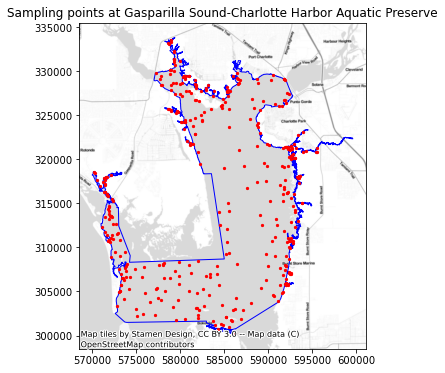

In [10]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [11]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

## 3.2 Dissolved Oxygen <a class="anchor" id="do"></a>

### 3.2.1 Regression Kriging (covariate: bathymetry) <a class="anchor" id="do_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

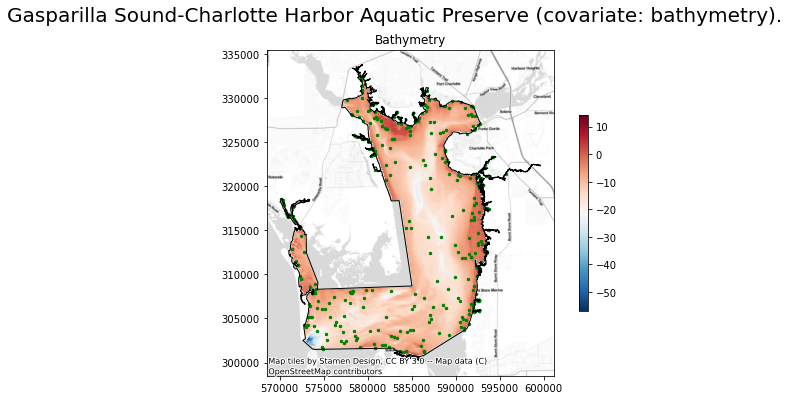

In [12]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

RK interpolation

In [13]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'bathymetry'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 401.16358375549316 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 384.59716176986694 seconds ---


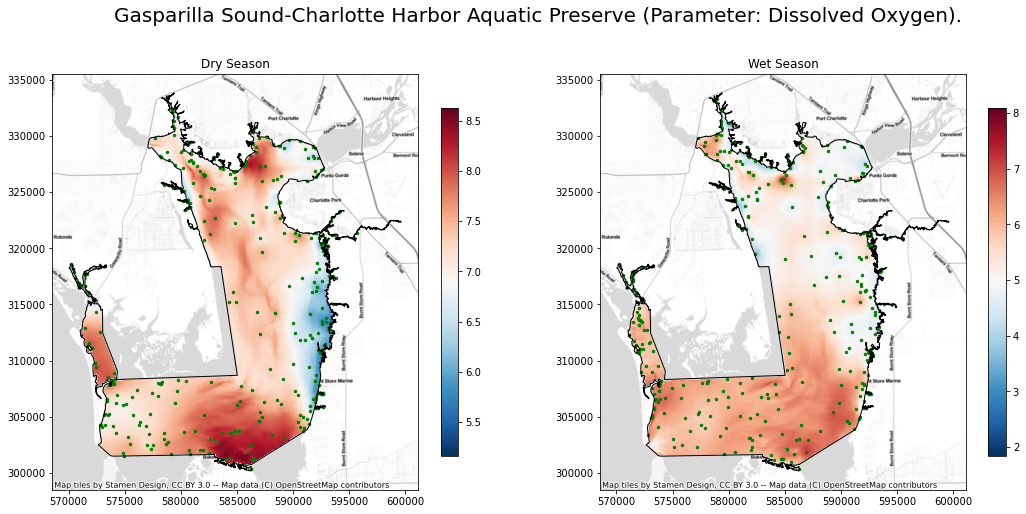

In [14]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.2.2 Regression Kriging (covariate: LDI) <a class="anchor" id="do_ldi"></a>


RK interpolation

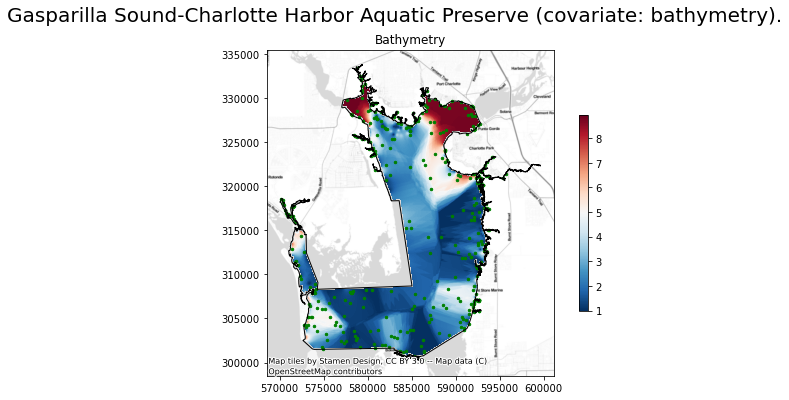

In [15]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/LDI/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

In [16]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'ldi'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 393.8952548503876 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 419.54173827171326 seconds ---


Plot the interpolation result

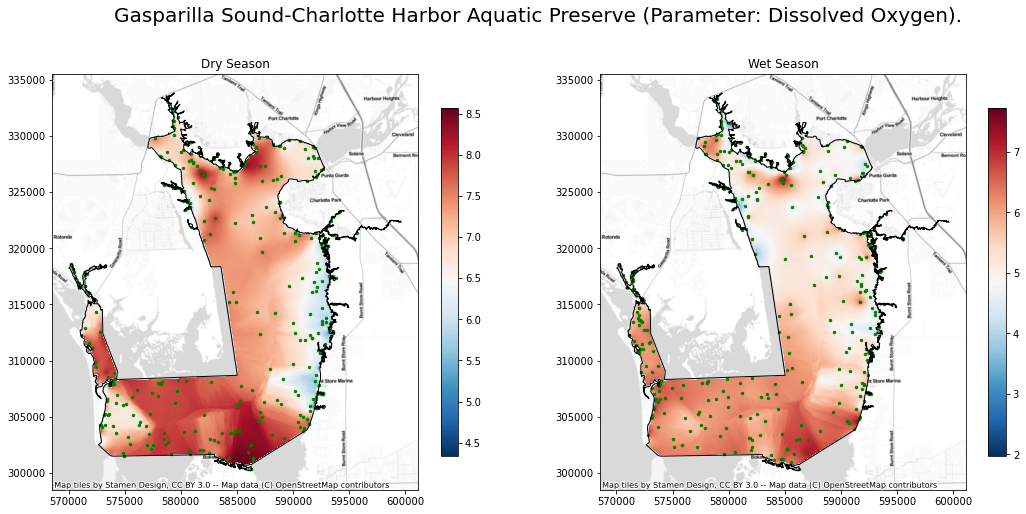

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1], fig)

### 3.2.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="do_ldi_bathy"></a>


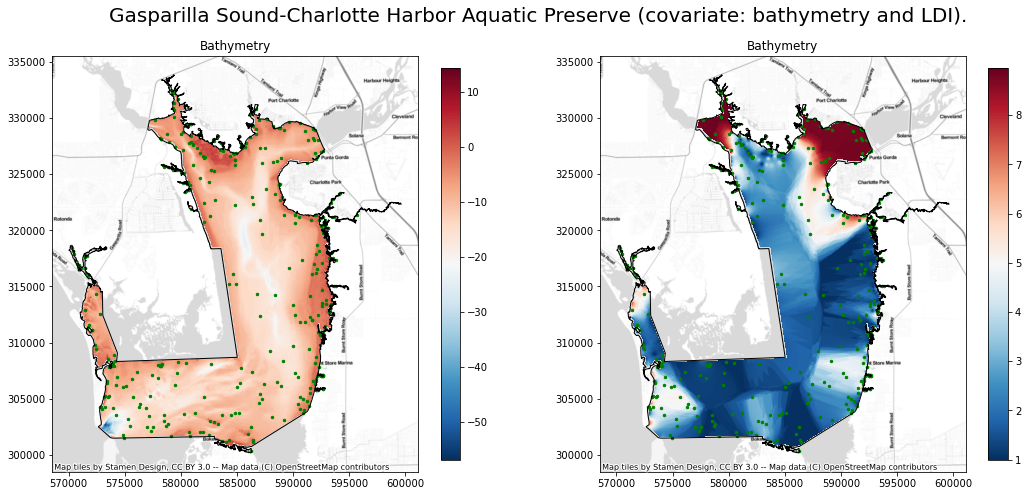

In [18]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry and LDI'),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[0], fig)

ra_fname = gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[1], fig)


In [19]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name), 'b_ldi'
in_explanatory_rasters = [gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area]),
                          gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 672.8776113986969 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 689.9957988262177 seconds ---


Plot interpolation results

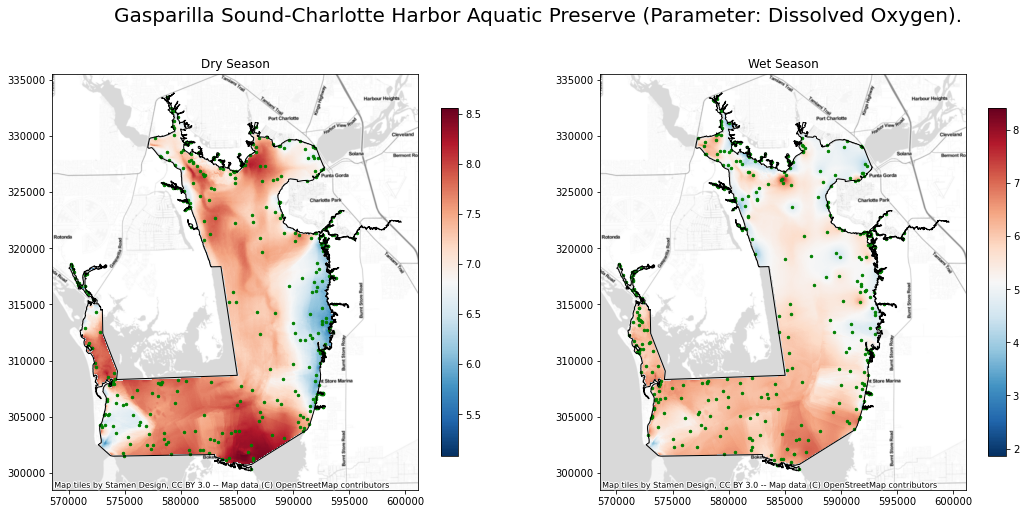

In [20]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


## 3.2.4 Interpolation Validation <a class="anchor" id="do_val"></a>

Validate RK with bathymetry

In [21]:
method, season, covariate = 'rk', 'dry', 'bathymetry'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat1 = misc.interpolation.extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat1 = misc.interpolation.extract_val_result(inLayer,covariate)

Display validation result

In [22]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat1)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat1)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0187,0.0123,1.6154


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.065,0.0321,1.7821


Validation of RK with ldi as covariate

In [23]:
method, season, covariate = 'rk', 'dry', 'ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat2 = misc.interpolation.extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat2 = misc.interpolation.extract_val_result(inLayer,covariate)

Display validation result

In [24]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat2)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat2)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,0.0244,0.0156,1.5903


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,0.04,0.0187,1.7528


Validate RK with Bathymetry & LDI

In [25]:
method, season, covariate = 'rk', 'dry', 'b_ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat3 = misc.interpolation.extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat3 = misc.interpolation.extract_val_result(inLayer,covariate)

Display validation result

In [26]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat3)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat3)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,0.0421,0.0239,1.5803


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,0.0711,0.034,1.7747


#### Summary of validation

In [27]:
sumStatDry_ch = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
sumStatWet_ch = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])

display("Summary of interpolation validation in dry season data")
display(sumStatDry_ch)

display("Summary of interpolation validation in wet season data")
display(sumStatWet_ch)

'Summary of interpolation validation in dry season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0187,0.0123,1.6154
ldi,0.0244,0.0156,1.5903
b_ldi,0.0421,0.0239,1.5803


'Summary of interpolation validation in wet season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0650,0.0321,1.7821
ldi,0.0400,0.0187,1.7528
b_ldi,0.0711,0.0340,1.7747


## 3.3 Interpolation of Salinity <a class="anchor" id="s"></a>

Select salinity data

In [34]:
# Set variables of the program
year = "2017"
Para = 'Salinity'
Para_ab = "S"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

# ---------------------------- Uncomment in the first run --------------------------

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_33420\1634840079.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_33420\1634840079.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


### 3.3.1 Regression Kriging of Salinity (covariate: bathymetry) <a class="anchor" id="s_bathy"></a>

In [35]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [36]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

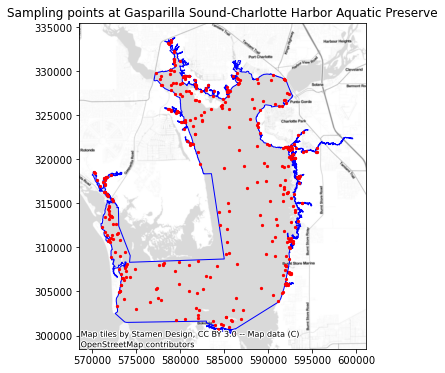

In [37]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [38]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

### 3.3.1 Regression Kriging  of Salinity (covariate: bathymetry) <a class="anchor" id="s_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

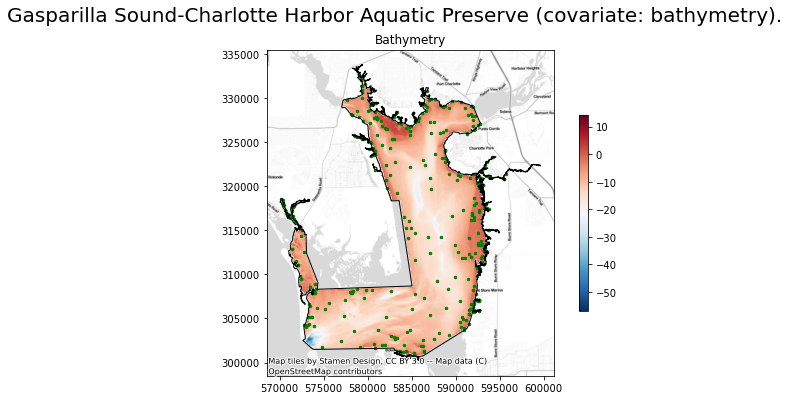

In [39]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

RK interpolation

In [40]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'bathymetry'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 455.2098228931427 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 436.2057762145996 seconds ---


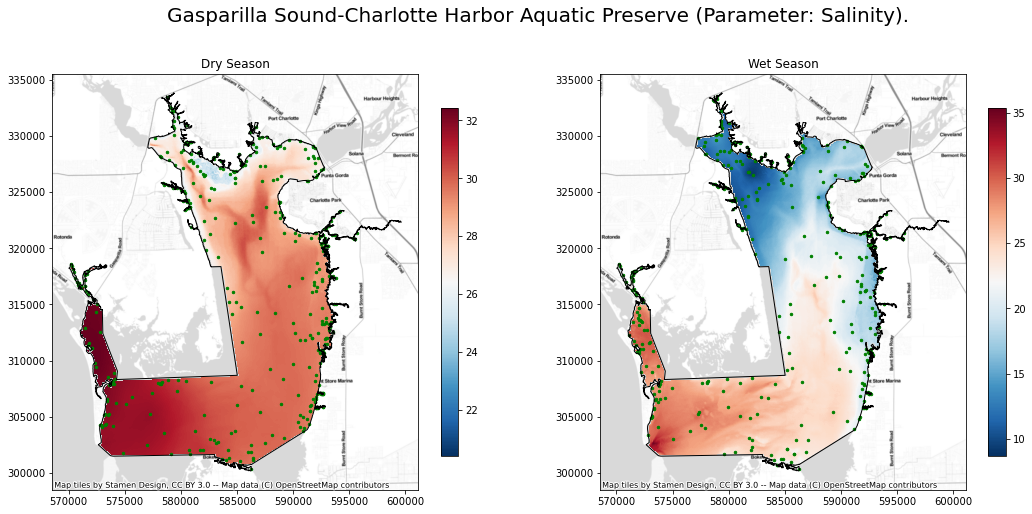

In [41]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.3.2 Regression Kriging of Salinity (covariate: LDI) <a class="anchor" id="s_ldi"></a>


RK interpolation

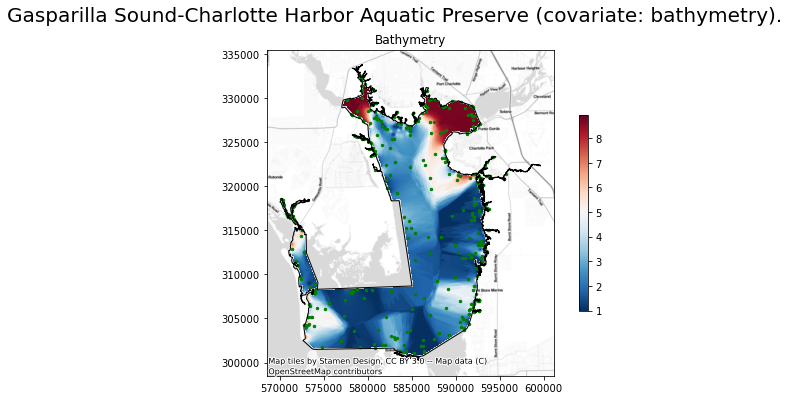

In [42]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/LDI/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

In [43]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'ldi'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 450.67966294288635 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 440.3116035461426 seconds ---


Plot the interpolation result

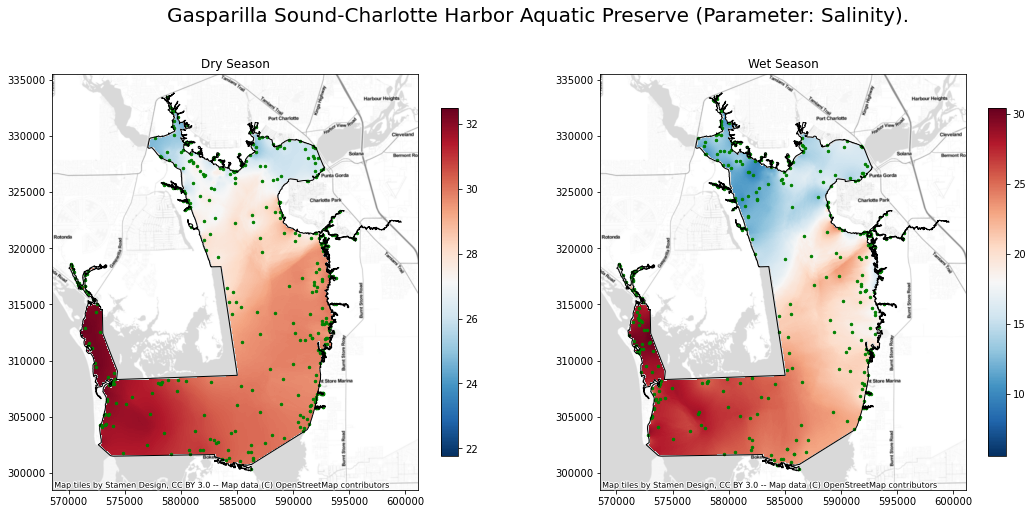

In [44]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1], fig)

### 3.3.3 Regression Kriging of Salinity (covariate: bathymetry + LDI) <a class="anchor" id="s_ldi_bathy"></a>


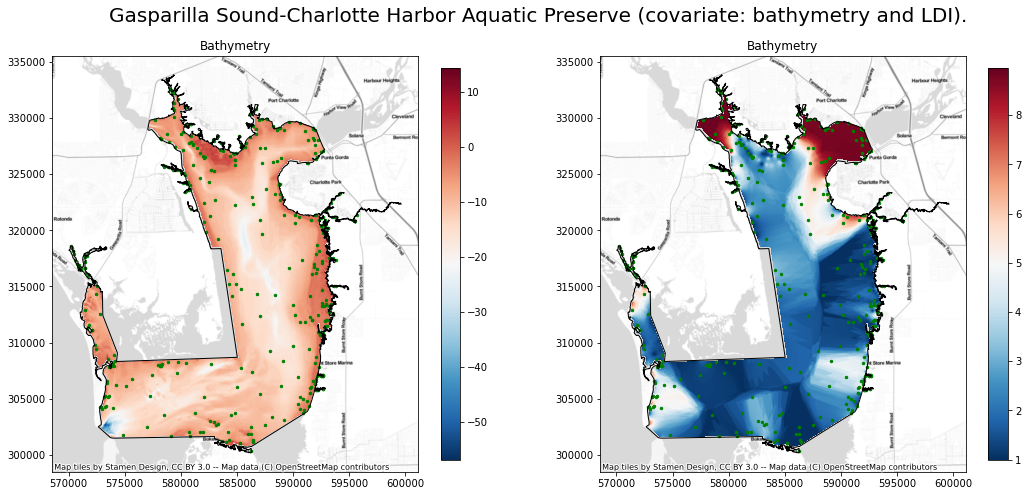

In [45]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry and LDI'),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[0], fig)

ra_fname = gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[1], fig)


In [46]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name), 'b_ldi'
in_explanatory_rasters = [gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area]),
                          gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 783.5490808486938 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 728.1223216056824 seconds ---


Plot interpolation results

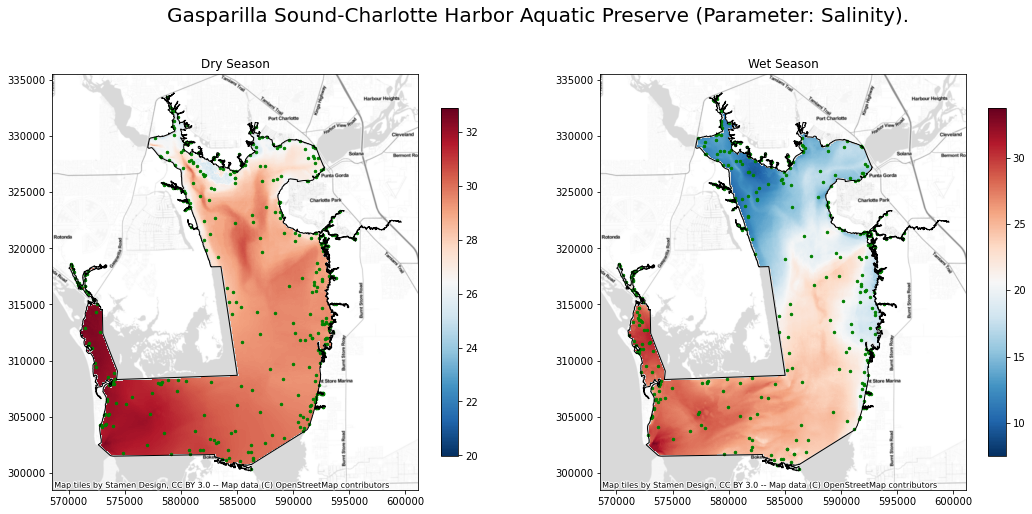

In [47]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.3.4 Interpolation Validation of Salinity <a class="anchor" id="s_val"></a>

Validate RK with bathymetry

In [48]:
def extract_val_result(inLayer, index):
    cvResult = arcpy.CrossValidation_ga(inLayer)
    Stat = pd.DataFrame(
                {
                  "meanError": round(float(cvResult.meanError),4),
                  "meanStandardizedError": round(float(cvResult.meanStandardized),4),
                  "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                              },index=[index])
    return Stat

In [49]:
method, season, covariate = 'rk', 'dry', 'bathymetry'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat1 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat1 = extract_val_result(inLayer,covariate)

Display validation result

In [50]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat1)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat1)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0399,-0.0222,2.5193


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.007,-0.005,8.8481


Validation of RK with ldi as covariate

In [51]:
method, season, covariate = 'rk', 'dry', 'ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat2 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat2 = extract_val_result(inLayer,covariate)

Display validation result

In [52]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat2)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat2)

Validation of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,-0.0766,-0.0339,2.5219


Validation of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
ldi,-0.0824,-0.017,8.967


Validate RK with Bathymetry & LDI

In [53]:
method, season, covariate = 'rk', 'dry', 'b_ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat3 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat3 = extract_val_result(inLayer,covariate)

Display validation result

In [54]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat3)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat3)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,-0.092,-0.0359,2.4049


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
b_ldi,-0.1274,-0.0189,8.8234


#### Summary of validation

In [55]:
sumStatDry_ch = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
sumStatWet_ch = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])

display("Summary of interpolation validation in dry season data")
display(sumStatDry_ch)

display("Summary of interpolation validation in wet season data")
display(sumStatWet_ch)

'Summary of interpolation validation in dry season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,-0.0399,-0.0222,2.5193
ldi,-0.0766,-0.0339,2.5219
b_ldi,-0.0920,-0.0359,2.4049


'Summary of interpolation validation in wet season data'

,meanError,meanStandardizedError,rootMeanSquareError
bathymetry,0.0070,-0.0050,8.8481
ldi,-0.0824,-0.0170,8.9670
b_ldi,-0.1274,-0.0189,8.8234


## 3.4 Interpolation of Total Nitrogen <a class="anchor" id="tn"></a>

Select data

In [89]:
# Set variables of the program
year = "2014"
Para = 'Total Nitrogen'
Para_ab = "TN"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_33420\1109426703.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_33420\1109426703.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Preview data

In [90]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [91]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

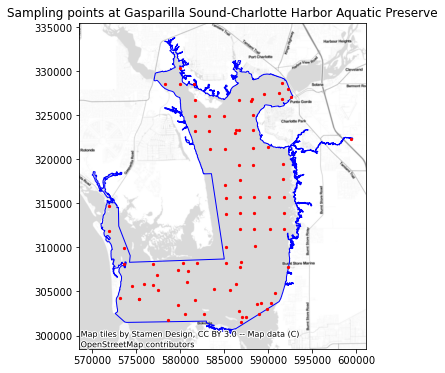

In [92]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [93]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

### 3.4.1 Regression Kriging of Total Nitrogen (covariate: bathymetry) <a class="anchor" id="tn_bathy"></a>

Run Oridinary Kriging with bathymetry as covariate

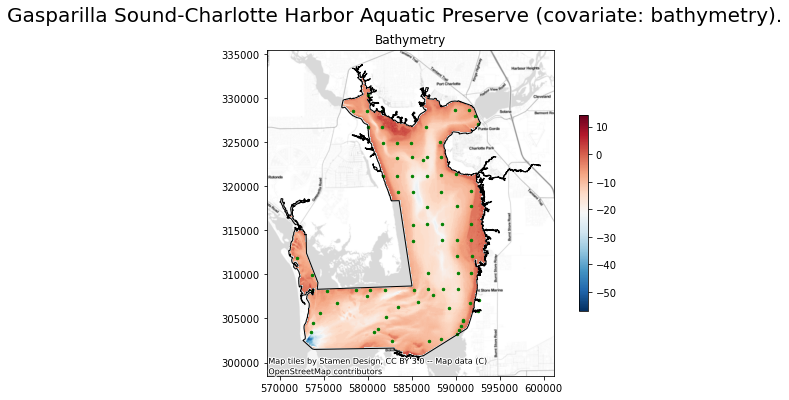

In [94]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

RK interpolation

In [ ]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'bathymetry'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.4.2 Regression Kriging of Total Nitrogen (covariate: LDI) <a class="anchor" id="tn_ldi"></a>


RK interpolation

In [ ]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/LDI/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

In [ ]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'ldi'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Plot the interpolation result

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1], fig)

### 3.4.3 Regression Kriging of Total Nitrogen (covariate: bathymetry + LDI) <a class="anchor" id="tn_b_ldi"></a>


In [ ]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry and LDI'),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[0], fig)

ra_fname = gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[1], fig)


In [ ]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name), 'b_ldi'
in_explanatory_rasters = [gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area]),
                          gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])]

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Plot interpolation results

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 3.4.4 Interpolation Validation of Total Nitrogen <a class="anchor" id="tn_val"></a>

Validate RK with bathymetry

In [ ]:
def extract_val_result(inLayer, index):
    cvResult = arcpy.CrossValidation_ga(inLayer)
    Stat = pd.DataFrame(
                {
                  "meanError": round(float(cvResult.meanError),4),
                  "meanStandardizedError": round(float(cvResult.meanStandardized),4),
                  "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                              },index=[index])
    return Stat

In [ ]:
method, season, covariate = 'rk', 'dry', 'bathymetry'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat1 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat1 = extract_val_result(inLayer,covariate)

Display validation result

In [ ]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat1)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat1)

Validation of RK with ldi as covariate

In [ ]:
method, season, covariate = 'rk', 'dry', 'ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat2 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat2 = extract_val_result(inLayer,covariate)

Display validation result

In [ ]:
print("Validation of Regression Kriging in dry season data")
display(dryRKStat2)
print("Validation of Regression Kriging in wet season data")
display(wetRKStat2)

Validate RK with Bathymetry & LDI

In [ ]:
method, season, covariate = 'rk', 'dry', 'b_ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

dryRKStat3 = extract_val_result(inLayer,covariate)

season = 'wet'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

wetRKStat3 = extract_val_result(inLayer,covariate)

Display validation result

In [ ]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat3)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat3)

#### Summary of validation

In [ ]:
sumStatDry_ch = pd.concat([dryRKStat1,dryRKStat2,dryRKStat3])
sumStatWet_ch = pd.concat([wetRKStat1,wetRKStat2,wetRKStat3])

display("Summary of interpolation validation in dry season data")
display(sumStatDry_ch)

display("Summary of interpolation validation in wet season data")
display(sumStatWet_ch)